In [120]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv
import scipy.io as sio

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Data from Matlab

In [121]:
# Points from matlab
data = sio.loadmat("D:\\Skole\\Semester 10\\Prosjektoppgave\\EPnP_Python-master\\input" + '\\input_data_noise.mat')

A = data['A']
Rt = data['Rt']

points = data['point']
n = len(points[0])
Xcam, Ximg_true, Ximg_pix_true, Ximg, Ximg_pix, Xworld= [], [], [], [], [], []
for p in points[0]:
    Xcam.append(p[0])
    Ximg_true.append(p[1])
    Ximg_pix_true.append(p[2])
    Ximg.append(p[3])
    Ximg_pix.append(p[4])
    Xworld.append(p[5])

Xcam = np.array(Xcam)
Ximg_true = np.array(Ximg_true)
Ximg_pix_true = np.array(Ximg_pix_true)
Ximg = np.array(Ximg)
Ximg_pix = np.array(Ximg_pix)
Xworld = np.array(Xworld)



n = len(Ximg_pix)

# Random data
focal = 800
u_0 = 320
v_0 = 240

# Transformation Matrix
transf_c_w = np.array([
    [0.7434,-0.6526, 0.1465, 0],
    [0.6274, 0.6044,-0.4910, 0],
    [0.2319, 0.4570, 0.8587, 0],
    [0     , 0     , 0     , 1]
])

# Parameter matrix
camera_para =  np.array([
    [focal,     0, u_0],
    [    0, focal, v_0],
    [    0,     0,   1]
])

pi_mat = np.eye(3,4)

# Define Control Points in World coor coor - control world
# Potenital error: Transpose or not?
ch_w = np.array([
    [1, 0, 0, 1], 
    [0, 1, 0, 1], 
    [0, 0, 1, 1],
    [0, 0, 0, 1]
]).T

c_w = pi_mat @ ch_w

## Computing alpha, M, kernel

In [122]:
# Cpmpute alphas
# Question: Why [0]?
X_w = Xworld.T[0]
Xh_w = np.concatenate((X_w, np.array([np.ones((n))])), axis=0)

alpha = np.matmul(np.linalg.inv(ch_w), Xh_w).T

In [123]:
# Calculate M matrix
# Question: Why error below?
M = np.empty((2*n,12))
for i in range(n):
    M[i*2,:]= np.array([
        alpha[i, 0] * focal, 0, alpha[i, 0] * (u_0 - Ximg_pix[i, 0]),
        alpha[i, 1] * focal, 0, alpha[i, 1] * (u_0 - Ximg_pix[i, 0]),
        alpha[i, 2] * focal, 0, alpha[i, 2] * (u_0 - Ximg_pix[i, 0]),
        alpha[i, 3] * focal, 0, alpha[i, 3] * (u_0 - Ximg_pix[i, 0])
    ])
    M[i*2+1,:] = np.array([
        0, alpha[i, 0] * focal, alpha[i, 0] * (v_0 - Ximg_pix[i, 1]),
        0, alpha[i, 1] * focal, alpha[i, 1] * (v_0 - Ximg_pix[i, 1]),
        0, alpha[i, 2] * focal, alpha[i, 2] * (v_0 - Ximg_pix[i, 1]),
        0, alpha[i, 3] * focal, alpha[i, 3] * (v_0 - Ximg_pix[i, 1])
    ])

C:\Users\runar\AppData\Local\Temp/ipykernel_12356/1510779535.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  M[i*2,:]= np.array([
C:\Users\runar\AppData\Local\Temp/ipykernel_12356/1510779535.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  M[i*2+1,:] = np.array([


In [124]:
# Compute M_T_M and V
M_T_M = np.matmul(M.T,M)
W, V = np.linalg.eig(M_T_M)
# Other method using svd
# Usvd, sig, Vsvd = np.linalg.svd(M)

# Finding smallest eigenvalues and their eigenvector
idx = W.argsort()
K = V[:, idx[:4]]
K = np.array(K)
kernel = np.array([K.T[3], K.T[2], K.T[1], K.T[0]]).T
print(K)

[[0.070 0.017 0.168 0.308]
 [-0.041 0.200 0.002 0.234]
 [0.499 -0.611 0.449 -0.017]
 [0.057 0.097 0.301 0.325]
 [0.049 0.181 -0.031 0.146]
 [0.445 0.693 0.382 -0.275]
 [0.031 -0.002 0.250 0.363]
 [0.041 0.173 -0.102 0.125]
 [0.549 -0.001 -0.584 0.463]
 [0.014 0.016 0.255 0.342]
 [0.006 0.180 -0.067 0.167]
 [0.487 -0.039 -0.220 -0.376]]


## Computing rho, L_6__

In [125]:
# Compute rho
rho = np.empty((6,1))
rho = np.array([
    np.linalg.norm(ch_w[:,0]-ch_w[:,1])**2,
    np.linalg.norm(ch_w[:,0]-ch_w[:,2])**2,
    np.linalg.norm(ch_w[:,0]-ch_w[:,3])**2,
    np.linalg.norm(ch_w[:,1]-ch_w[:,2])**2,
    np.linalg.norm(ch_w[:,1]-ch_w[:,3])**2,
    np.linalg.norm(ch_w[:,2]-ch_w[:,3])**2
])

In [126]:
# Compute L_6_10
# Did not understand this one, "borrowed" from epnp python dude
# Error: kernel in line 8
L_6_10 = np.zeros((6,10))

v = []
for i in range(4):
    v.append(kernel[:, i])

dv = []

for r in range(4):
    dv.append([])
    for i in range(3):
        for j in range(i+1, 4):
            dv[r].append(v[r][3*i:3*(i+1)]-v[r][3*j:3*(j+1)])

index = [
    (0, 0),
    (0, 1),
    (1, 1),
    (0, 2),
    (1, 2),
    (2, 2),
    (0, 3),
    (1, 3),
    (2, 3),
    (3, 3)
    ]

for i in range(6):
    j = 0
    for a, b in index:
        L_6_10[i, j] = np.matmul(dv[a][i], dv[b][i].T)
        if a != b:
            L_6_10[i, j] *= 2
        j += 1

In [127]:
# Computing L_6_3
L_6_3 = L_6_10[:, (5,8,9)]

# Computing L_6_6
L_6_6 = L_6_10[:, (2, 4, 7, 5, 8, 9)]

## Calculating Cc, Xc, sc for each Case

In [128]:
# Trying to calculate beta 1
def calc_beta_1(V, C):
    # Hard coding, maybe efficient afterwards
    temp1  = np.linalg.norm(V[0:3]-V[3:6]) *np.linalg.norm(C[0,:]-C[1,:])
    temp1 += np.linalg.norm(V[0:3]-V[6:9]) *np.linalg.norm(C[0,:]-C[2,:])
    temp1 += np.linalg.norm(V[0:3]-V[9:12])*np.linalg.norm(C[0,:]-C[3,:])
    temp1 += np.linalg.norm(V[3:6]-V[6:9]) *np.linalg.norm(C[1,:]-C[2,:])
    temp1 += np.linalg.norm(V[3:6]-V[9:12])*np.linalg.norm(C[1,:]-C[3,:])
    temp1 += np.linalg.norm(V[6:9]-V[9:12])*np.linalg.norm(C[2,:]-C[3,:])

    temp2  = np.linalg.norm(V[0:3]-V[3:6]) **2
    temp2 += np.linalg.norm(V[0:3]-V[6:9]) **2
    temp2 += np.linalg.norm(V[0:3]-V[9:12])**2
    temp2 += np.linalg.norm(V[3:6]-V[6:9]) **2
    temp2 += np.linalg.norm(V[3:6]-V[9:12])**2
    temp2 += np.linalg.norm(V[6:9]-V[9:12])**2

    return temp1/temp2

In [129]:
# Computing betas
# Case 1 - N = 1
beta_1_1 = 100 #[calc_beta_1(K[:, :1], ch_w)]
X1 = beta_1_1 * K[:, :1] # X


# Case 2 - N = 2
# Question: Why K[1] -> K[0]
# Question: Why signs
betas_2 = np.matmul(np.linalg.pinv(L_6_3), rho)
beta_2_1 = np.sqrt(abs(betas_2[0]))
beta_2_2 = np.sqrt(abs(betas_2[2])) * np.sign(betas_2[1]) * np.sign(betas_2[0])
X2 = beta_2_1 * K[:,1] + beta_2_2 * K[:,0]


# Case 3 - N = 3
# Question: Why K[2] -> K[1] -> K[0]
# Question: Why signs in that order
betas_3 = np.matmul(np.linalg.inv(L_6_6), rho)
beta_3_1 = math.sqrt(abs(betas_3[0]))
beta_3_2 = math.sqrt(abs(betas_3[3])) * np.sign(betas_3[1]) * np.sign(betas_3[0])
beta_3_3 = math.sqrt(abs(betas_3[5])) * np.sign(betas_3[2]) * np.sign(betas_3[0])
X3 = beta_3_1 * K[:,2] + beta_3_2 * K[:,1] + beta_3_3 * K[:,0]

In [130]:
# Calculating Cc, Xc, sc for each Case
# Question: Why sign at the end?
# Case 1
Cc_1 = []
for i in range(4):
    Cc_1.append(X1[(3 * i) : (3 * (i + 1))])
Cc_1 = np.array(Cc_1).reshape((4,3))

Xc_1 = np.matmul(alpha, Cc_1)

centr_w = np.mean(Xworld, axis=0)
centroid_w = np.tile(centr_w.reshape((1,3)), (n,1))
tmp1 = Xworld.reshape((n,3)) - centroid_w
dist_w = np.sqrt(np.sum(tmp1**2, axis=1))

print(centr_w.shape)

centr_c = np.mean(Xc_1, axis=0)
centroid_c = np.tile(centr_c.reshape((1,3)), (n,1))
tmp2 = Xc_1.reshape((n,3)) - centroid_c
dist_c = np.sqrt(np.sum(tmp2**2, axis=1))

sc_1_1 = np.matmul(dist_c.T, dist_c) ** -1
sc_1_2 = np.matmul(dist_c.T, dist_w)
sc_1 = sc_1_1 * sc_1_2

Cc_1 *= sc_1
Xc_1 = np.matmul(alpha, Cc_1)

for x in Xc_1:
    if x[-1] < 0:
        Xc_1 *= -1
        Cc_1 *= -1

(3, 1)


In [131]:
# Case 2
Cc_2 = []
for i in range(4):
    Cc_2.append(X2[(3 * i) : (3 * (i + 1))])
Cc_2 = np.array(Cc_2).reshape((4,3))

Xc_2 = np.matmul(alpha, Cc_2)

centr_w = np.mean(Xworld, axis=0)
centroid_w = np.tile(centr_w.reshape((1,3)), (n,1))
tmp1 = Xworld.reshape((n,3))-centroid_w
dist_w = np.sqrt(np.sum(tmp1**2, axis=1))

centr_c = np.mean(Xc_2, axis=0)
centroid_c = np.tile(centr_c.reshape((1,3)), (n,1))
tmp2 = Xc_2.reshape((n,3))-centroid_c
dist_c = np.sqrt(np.sum(tmp2**2, axis=1))

sc_2_1 = np.matmul(dist_c.T, dist_c) ** -1
sc_2_2 = np.matmul(dist_c.T, dist_w)
sc_2 = sc_2_1 * sc_2_2

Cc_2 *= sc_2
Xc_2 = np.matmul(alpha, Cc_2)
for x in Xc_2:
    if x[-1] < 0:
        Xc_2 *= -1
        Cc_2 *= -1


In [132]:
# Case 3
Cc_3 = []
for i in range(4):
    Cc_3.append(X3[(3 * i) : (3 * (i + 1))])
Cc_3 = np.array(Cc_3).reshape((4,3))

Xc_3 = np.matmul(alpha, Cc_3)

centr_w = np.mean(Xworld, axis=0)
centroid_w = np.tile(centr_w.reshape((1,3)), (n,1))
tmp1 = Xworld.reshape((n,3))-centroid_w
dist_w = np.sqrt(np.sum(tmp1**2, axis=1))

centr_c = np.mean(Xc_3, axis=0)
centroid_c = np.tile(centr_c.reshape((1,3)), (n,1))
tmp2 = Xc_3.reshape((n,3))-centroid_c
dist_c = np.sqrt(np.sum(tmp2**2, axis=1))

sc_3_1 = np.matmul(dist_c.T, dist_c) ** -1
sc_3_2 = np.matmul(dist_c.T, dist_w)
sc_3 = sc_3_1 * sc_3_2

Cc_3 *= sc_3
Xc_3 = np.matmul(alpha, Cc_3)
for x in Xc_3:
    if x[-1] < 0:
        Xc_3 *= -1
        Cc_3 *= -1


In [133]:
beta = calc_beta_1(K[:,0],ch_w)
beta

16.749310296509876

## Calculating Transformation matrix

In [134]:
# Calculating Transformation matrix
# Case 1
wpts = Xworld
cpts = Xc_1

wcent = np.tile(np.mean(wpts, axis=0).reshape((1, 3)), (n, 1))
ccent = np.tile(np.mean(cpts, axis=0).reshape((1, 3)), (n, 1))

wpts = wpts.reshape((n, 3)) - wcent
cpts = cpts.reshape((n, 3)) - ccent

M = np.matmul(cpts.T, wpts)

U, S, V = np.linalg.svd(M)
R_1 = np.matmul(U, V)

if np.linalg.det(R_1) < 0:
    R_1 = - R_1
    
T_1 = ccent[0].transpose() - np.matmul(R_1, wcent[0].transpose())

Rt_1 = np.concatenate((R_1.reshape((3, 3)), T_1.reshape((3, 1))), axis=1)

In [135]:
# Case 2
wpts = Xworld
cpts = Xc_2

wcent = np.tile(np.mean(wpts, axis=0).reshape((1, 3)), (n, 1))
ccent = np.tile(np.mean(cpts, axis=0).reshape((1, 3)), (n, 1))

wpts = wpts.reshape((n, 3)) - wcent
cpts = cpts.reshape((n, 3)) - ccent

M = np.matmul(cpts.T, wpts)

U, S, V = np.linalg.svd(M)
R_2 = np.matmul(U, V)

if np.linalg.det(R_2) < 0:
    R_2 = - R_2
    
T_2 = ccent[0].transpose() - np.matmul(R_2, wcent[0].transpose())

Rt_2 = np.concatenate((R_2.reshape((3, 3)), T_2.reshape((3, 1))), axis=1)

In [136]:
# Case 3
wpts = Xworld
cpts = Xc_3

wcent = np.tile(np.mean(wpts, axis=0).reshape((1, 3)), (n, 1))
ccent = np.tile(np.mean(cpts, axis=0).reshape((1, 3)), (n, 1))

wpts = wpts.reshape((n, 3)) - wcent
cpts = cpts.reshape((n, 3)) - ccent

M = np.matmul(cpts.T, wpts)

U, S, V = np.linalg.svd(M)
R_3 = np.matmul(U, V)

if np.linalg.det(R_3) < 0:
    R_3 = - R_3
    
T_3 = ccent[0].transpose() - np.matmul(R_3, wcent[0].transpose())

Rt_3 = np.concatenate((R_3.reshape((3, 3)), T_3.reshape((3, 1))), axis=1)

In [137]:
def reprojection_error_usingRT(Xw, U, RT):
        A = camera_para
        P = np.matmul(A[:, :3], RT)
        Xw_h = np.concatenate((Xw.reshape((n, 3)), np.array([np.ones((n))]).T), axis=1)
    
        Urep = np.matmul(P, Xw_h.T).T
        Urep[:, 0] = Urep[:, 0] / Urep[:, 2]
        Urep[:, 1] = Urep[:, 1] / Urep[:, 2]
        err = np.sqrt((U[:, 0] - Urep[:, 0].reshape((n, 1))) ** 2 + (U[:, 1] - Urep[:, 1].reshape((n, 1))) ** 2)
        err = np.sum(err, axis=0) / n

        return err[0]

In [138]:
err_1 = reprojection_error_usingRT(Xworld, Ximg_pix, Rt_1)
err_2 = reprojection_error_usingRT(Xworld, Ximg_pix, Rt_2)
err_3 = reprojection_error_usingRT(Xworld, Ximg_pix, Rt_3)
print(err_1, err_2, err_3)

12.702209361054535 16.34552890678184 23.356483432891583


In [139]:
def plot_3d_reconstruction( method, Xc):
        fig = plt.figure()
        fig.set_size_inches(18.5, 13)
        axes = fig.add_subplot(1, 1, 1)
        plt.plot(0, 0, 'ok')
        for p in Xcam:
            plt.plot(p[0], p[1], '.r')
        for p in Xc:
            plt.plot(p[0], p[1], 'xg')
        axes.set_title(method + ' - Reprojection Error', fontsize=18)
        plt.grid()

## OpenCV

In [140]:
# success_cv, rotation_cv, translation_cv = cv.solvePnP(Xworld, Ximg_pix_true, camera_para, None )
# print(success_cv,"\n" ,rotation_cv,"\n",translation_cv)

## Plotting

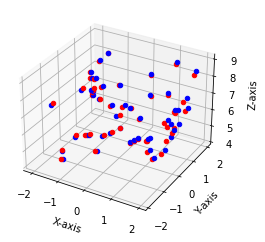

In [141]:
fig_1 = plt.figure()
ax = fig_1.add_subplot(projection='3d')
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
# ax.set_zlim(-3,3)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Xc_1 = Xc_1.T
scaling = 10

for i in range(n):
    ax.scatter(Xcam[i][0], Xcam[i][1], Xcam[i][2], c='blue')
    ax.scatter(Xc_1[i][0], Xc_1[i][1], Xc_1[i][2], c='red')
    # ax.scatter(Xc_2[0][i], Xc_2[1][i], Xc_2[2][i], c='green')
plt.show()

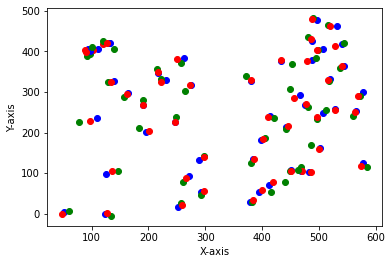

In [142]:
#Plotting points - Decomment to see "photo of points"

pix_c_1 = Xc_1
pix_c_1 = pix_c_1*(1/pix_c_1[:,2].reshape((50,1)))
pix_c_1 = pix_c_1 @ camera_para.T

fig_1 = plt.figure()
ax = fig_1.add_subplot()
# ax.set_xlim(0,u_0*2)
# ax.set_ylim(0,v_0*2)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

for i in range(n):
    ax.scatter(Ximg_pix_true[i][0], Ximg_pix_true[i][1], c="blue")
    ax.scatter(Ximg_pix[i][0], Ximg_pix[i][1], c="green")
    ax.scatter(pix_c_1[i,0], pix_c_1[i,1], c="red")
plt.show()